<a href="https://colab.research.google.com/github/elka97/GB_PyTorch/blob/main/HW_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# hw

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:

1. Создать Dataset для загрузки данных

2. Обернуть его в Dataloader

3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)

4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [ ]:
# !pip install torch

# imports

In [2]:
import numpy as np
import pandas as pd
import torch as torch
from torchvision import transforms
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import datetime

# load dataset

In [3]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24


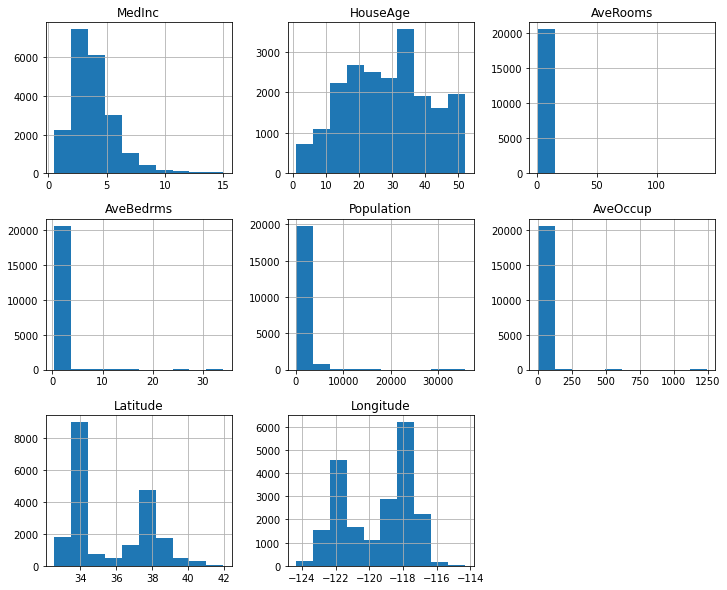

In [4]:
X.hist(figsize = (12,10))
plt.show()

In [5]:
y.head(3)

0    4.526
1    3.585
2    3.521
Name: MedHouseVal, dtype: float64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15480, 8) (5160, 8) (15480,) (5160,)


# Custom dataset

In [7]:
class CaliforniaDataset(torch.utils.data.Dataset):
  '''
  Prepare the california dataset for regression
  '''
  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      if scale_data:
          X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(np.array(y))

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

# Net

In [8]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron with batchnorm 1d and dropout for regression
  '''
  def __init__(self, features_num):
    super(MLP, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(features_num, 64),
      nn.ReLU(),
      nn.BatchNorm1d(64),
      nn.Dropout(0.25),
      nn.Linear(64, 32),
      nn.ReLU(),

      # nn.Linear(32, 64),
      # nn.ReLU(),
      # nn.BatchNorm1d(64),
      # nn.Dropout(0.25),
      # nn.Linear(64, 32),
      # nn.ReLU(), 

      nn.Linear(32, 1)
    )

  def forward(self, x):   
    return self.layers(x)

class MLPNoBatchNormDropout(nn.Module):
  '''
    Multilayer Perceptron with batchnorm 1d and dropout for regression
  '''
  def __init__(self, features_num):
    super(MLPNoBatchNormDropout, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(features_num, 64),
      nn.ReLU(),     
      nn.Linear(64, 32),
      nn.ReLU(),

      # nn.Linear(32, 64),
      # nn.ReLU(),    
      # nn.Linear(64, 32),
      # nn.ReLU(), 

      nn.Linear(32, 1)
    )

  def forward(self, x):   
    return self.layers(x)

# train/test methods

In [70]:
def train_one_epoch(epoch_index, optimizer, loss_fn, tb_writer=None):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):

        # Get and prepare inputs
        inputs, labels = data[0].float().to(device), data[1].float().to(device)
        labels = labels.reshape((labels.shape[0], 1))

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % batches_number == 0:
          last_loss = running_loss / 1000 # loss per batch
          # print(f'EPOCH {epoch_index + 1}:  batch {i + 1} loss: {last_loss}')

          if tb_writer is not None:
            tb_x = epoch_index * len(train_loader) + i + 1            
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        running_loss = 0.
    
    return last_loss


def run_model(model, optimizer, loss_fn, best_vloss = 1_000_000., epochs=5):

  for epoch_number in range(epochs):
    # print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, optimizer, loss_fn, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata[0].float().to(device), vdata[1].float().to(device)
        vlabels = vlabels.reshape((vlabels.shape[0], 1))

        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print(f'epoch {epoch_number} LOSS train {avg_loss:.4f} valid loss: {avg_vloss:.4f}')

    # Log the running loss averaged per batch
    # for both training and validation
    if writer is not None:
      writer.add_scalars('Training vs. Validation Loss', epoch_number + 1)
      writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

In [71]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
writer = None #SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

# loaders

In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [73]:
features_num=len(X_train.columns)
batches_number=10

lr=1e-3
epochs=10
loss = nn.MSELoss()

# REPRODUCIBILITY
torch.manual_seed(13)

In [74]:
# batches
train_batch_size=len(X_train)//batches_number
test_batch_size=len(X_test)//batches_number

train_dataset = CaliforniaDataset(X=X_train, y=y_train, scale_data=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)

test_dataset = CaliforniaDataset(X=X_test, y=y_test, scale_data=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

for batch, label in train_loader:
    print(f"batch.shape={batch.shape}")
    break

for batch, label in test_loader:
    print(f"test batch.shape={batch.shape}")
    break

batch.shape=torch.Size([1548, 8])
test batch.shape=torch.Size([516, 8])


# SGD

In [75]:
#  without 
model=MLPNoBatchNormDropout(features_num).to(device)
run_model(model=model, optimizer=torch.optim.SGD(model.parameters(), lr=lr), loss_fn=loss, epochs=epochs)

epoch 0 LOSS train 0.0046 valid loss: 5.9362
epoch 1 LOSS train 0.0043 valid loss: 5.5537
epoch 2 LOSS train 0.0042 valid loss: 5.1918
epoch 3 LOSS train 0.0038 valid loss: 4.8498
epoch 4 LOSS train 0.0036 valid loss: 4.5264
epoch 5 LOSS train 0.0032 valid loss: 4.2226
epoch 6 LOSS train 0.0031 valid loss: 3.9387
epoch 7 LOSS train 0.0028 valid loss: 3.6753
epoch 8 LOSS train 0.0026 valid loss: 3.4334
epoch 9 LOSS train 0.0024 valid loss: 3.2133


In [76]:
model=MLP(features_num).to(device)
run_model(model=model, optimizer=torch.optim.SGD(model.parameters(), lr=lr), loss_fn=loss, epochs=epochs)

epoch 0 LOSS train 0.0053 valid loss: 6.6393
epoch 1 LOSS train 0.0045 valid loss: 6.0917
epoch 2 LOSS train 0.0044 valid loss: 5.5275
epoch 3 LOSS train 0.0038 valid loss: 5.0212
epoch 4 LOSS train 0.0037 valid loss: 4.5758
epoch 5 LOSS train 0.0032 valid loss: 4.2247
epoch 6 LOSS train 0.0026 valid loss: 3.8982
epoch 7 LOSS train 0.0025 valid loss: 3.5914
epoch 8 LOSS train 0.0023 valid loss: 3.3299
epoch 9 LOSS train 0.0019 valid loss: 3.1129


# RMSprop

In [77]:
#  without 
model=MLPNoBatchNormDropout(features_num).to(device)
run_model(model=model, optimizer=torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99), loss_fn=loss, epochs=epochs)

epoch 0 LOSS train 0.0052 valid loss: 1.9161
epoch 1 LOSS train 0.0010 valid loss: 1.4999
epoch 2 LOSS train 0.0019 valid loss: 1.2903
epoch 3 LOSS train 0.0007 valid loss: 1.1676
epoch 4 LOSS train 0.0006 valid loss: 1.0044
epoch 5 LOSS train 0.0006 valid loss: 0.9122
epoch 6 LOSS train 0.0005 valid loss: 0.8403
epoch 7 LOSS train 0.0005 valid loss: 0.7680
epoch 8 LOSS train 0.0005 valid loss: 0.7189
epoch 9 LOSS train 0.0005 valid loss: 0.6839


In [78]:
model=MLP(features_num).to(device)
run_model(model=model, optimizer=torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99), loss_fn=loss, epochs=epochs)

epoch 0 LOSS train 0.0061 valid loss: 3.8451
epoch 1 LOSS train 0.0009 valid loss: 2.5952
epoch 2 LOSS train 0.0006 valid loss: 1.8795
epoch 3 LOSS train 0.0005 valid loss: 1.4385
epoch 4 LOSS train 0.0005 valid loss: 1.3112
epoch 5 LOSS train 0.0006 valid loss: 1.2074
epoch 6 LOSS train 0.0005 valid loss: 1.0983
epoch 7 LOSS train 0.0005 valid loss: 1.1153
epoch 8 LOSS train 0.0005 valid loss: 1.0255
epoch 9 LOSS train 0.0004 valid loss: 0.9909


# Adam

In [79]:
#  without 
model=MLPNoBatchNormDropout(features_num).to(device)
run_model(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=lr), loss_fn=loss, epochs=epochs)

epoch 0 LOSS train 0.0051 valid loss: 5.8621
epoch 1 LOSS train 0.0045 valid loss: 4.8847
epoch 2 LOSS train 0.0036 valid loss: 3.8174
epoch 3 LOSS train 0.0029 valid loss: 2.8618
epoch 4 LOSS train 0.0020 valid loss: 2.2439
epoch 5 LOSS train 0.0013 valid loss: 1.9409
epoch 6 LOSS train 0.0018 valid loss: 1.7589
epoch 7 LOSS train 0.0008 valid loss: 1.6174
epoch 8 LOSS train 0.0008 valid loss: 1.4761
epoch 9 LOSS train 0.0008 valid loss: 1.3563


In [80]:
model=MLP(features_num).to(device)
run_model(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=lr), loss_fn=loss, epochs=epochs)

epoch 0 LOSS train 0.0060 valid loss: 6.7074
epoch 1 LOSS train 0.0043 valid loss: 5.4453
epoch 2 LOSS train 0.0033 valid loss: 4.0285
epoch 3 LOSS train 0.0022 valid loss: 2.8728
epoch 4 LOSS train 0.0017 valid loss: 2.0833
epoch 5 LOSS train 0.0010 valid loss: 1.6017
epoch 6 LOSS train 0.0009 valid loss: 1.2853
epoch 7 LOSS train 0.0008 valid loss: 1.0799
epoch 8 LOSS train 0.0006 valid loss: 1.0085
epoch 9 LOSS train 0.0007 valid loss: 0.9317


лучший результат получился с оптимизатором RMSprop, с небольшой разницей с Adam. 

Для всех оптимизаторов добавление BatchNorm и Dropout улучшает тестовую оценку (особенно для SGD), но зависит от строения самой сети и других параметров.

качество прогнозирования очень зависит от размера батча (можно регулировать batches_number), learning rate i t.d.

